### Data Scientist Nano Degree - Capstone Project 
### Car Booking Analysis and Prediction
### Tarek Abd ElRahman Ahmed ElAyat

#### Let's import the needed libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

import xgboost as xgb
from sklearn import preprocessing
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def print_model_scores(model, X_train, X_test, y_train, y_test):
    '''
    INPUT:
    model - the regression model
    X_train - pandas dataframe for the training dataset
    X_test - pandas dataframe for the test dataset
    y_train - pandas dataframe for the training label
    y_test - pandas dataframe for the test label
    
    OUTPUT:
    y_train_preds - panadas dataframe for the y_train prediction
    y_test_preds - panadas dataframe for the y_test prediction
    print scores 
    '''
    
    #Predict and score the model on training data
    y_train_preds = model.predict(X_train) 
    print("The r-squared score for our model on Training data is {} on {} values.".format(r2_score(y_train, y_train_preds), len(y_train)))
    print("The mean_squared_error score for our model on Training data is {} on {} values.".format(mean_squared_error(y_train, y_train_preds), len(y_train)))
    print("The root_mean_squared_error score for our model on Training data is {} on {} values.".format(sqrt(mean_squared_error(y_train, y_train_preds)), len(y_train)))

    print(" ")
    #Predict and score the model on test data
    y_test_preds = model.predict(X_test) 
    print("The r-squared score for our model on Testing data is {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test)))
    print("The mean_squared_error score for our model on Testing data is {} on {} values.".format(mean_squared_error(y_test, y_test_preds), len(y_test)))
    print("The root_mean_squared_error score for our model on Testing data is {} on {} values.".format(sqrt(mean_squared_error(y_test, y_test_preds)), len(y_test)))
    
    return y_train_preds, y_test_preds


In [3]:
def create_dummy_df(df, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    cat_cols = df.select_dtypes(include=['object']).columns
    
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [4]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = coefficients
    coefs_df['abs_coefs'] = np.abs(coefficients)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

### Load the training data and lookup files

In [5]:
df_taxi = pd.read_csv('C:\\Users\\tayat\\Documents\\Capstone Project\\NYC Dataset\\taxi_onefile.csv')
df_lookup_zone = pd.read_csv('C:\\Users\\tayat\\Documents\\Capstone Project\\NYC Dataset\\taxi+_zone_lookup.csv')

In [6]:
pd.set_option('display.max_rows', 50)

### Basic data exploration, list the columns with their data types and describe the features

In [7]:
df_taxi.shape

(42821916, 18)

In [8]:
df_taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1.0,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1.0,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1.0,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2.0,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,N,236,236,1.0,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2.0,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2.0,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,N,193,193,2.0,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN


### List the columns, dtypes, and describe the features

In [9]:
df_taxi.dtypes

VendorID                 float64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtype: object

In [10]:
# from the below describtion we notice that there are unlogical (-ve values), missing values and outliers which needs cleaning
df_taxi.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
VendorID,42706377.0,1.644342,0.501307,1.00,1.00,2.00,2.00,4.00
passenger_count,42706377.0,1.562970,1.210514,0.00,1.00,1.00,2.00,9.00
trip_distance,42821916.0,2.986702,4.856197,-18739.24,0.97,1.61,3.02,831.80
RatecodeID,42706377.0,1.061002,0.742314,1.00,1.00,1.00,1.00,99.00
PULocationID,42821916.0,163.280894,66.043385,1.00,116.00,162.00,233.00,265.00
DOLocationID,42821916.0,161.517654,70.257471,1.00,107.00,162.00,233.00,265.00
payment_type,42706377.0,1.288448,0.477927,1.00,1.00,1.00,2.00,5.00
fare_amount,42821916.0,13.278955,186.922325,-530.00,6.50,9.50,14.50,943274.80
extra,42821916.0,1.015128,1.219016,-60.00,0.00,0.50,2.50,535.38
mta_tax,42821916.0,0.494820,0.063083,-0.50,0.50,0.50,0.50,75.00


### Count missing data per feature

In [8]:
total = df_taxi.isnull().sum()
percent = (df_taxi.isnull().sum()/df_taxi.isnull().count())
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(100)

,Total,Percent
VendorID,115539,0.002698
tpep_pickup_datetime,0,0.000000
tpep_dropoff_datetime,0,0.000000
passenger_count,115539,0.002698
trip_distance,0,0.000000
RatecodeID,115539,0.002698
store_and_fwd_flag,115539,0.002698
PULocationID,0,0.000000
DOLocationID,0,0.000000
payment_type,115539,0.002698


## Feature Engineering:
### Extract the engineered features from pickup and dropoff times and then drop these two columns

In [8]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

df_taxi['tpep_pickup_datetime'] = pd.to_datetime(df_taxi['tpep_pickup_datetime'])
df_taxi['tpep_dropoff_datetime'] = pd.to_datetime(df_taxi['tpep_dropoff_datetime'])
df_taxi['tripduration_mins'] = ((df_taxi['tpep_dropoff_datetime'] - df_taxi['tpep_pickup_datetime']).dt.total_seconds()/60).astype(float)

df_taxi['year'] = pd.DatetimeIndex(df_taxi['tpep_pickup_datetime']).year
df_taxi['month'] = pd.DatetimeIndex(df_taxi['tpep_pickup_datetime']).month
df_taxi['day'] = pd.DatetimeIndex(df_taxi['tpep_pickup_datetime']).day
df_taxi['hour'] = pd.DatetimeIndex(df_taxi['tpep_pickup_datetime']).hour
df_taxi['dayofweek'] = pd.DatetimeIndex(df_taxi['tpep_pickup_datetime']).dayofweek
df_taxi['weekendflag'] = (df_taxi['dayofweek']>=5).astype(int)

cal = calendar()
holidays = cal.holidays(start=df_taxi['tpep_pickup_datetime'].min(), end=df_taxi['tpep_pickup_datetime'].max())
df_taxi['holidayflag'] = (df_taxi['tpep_pickup_datetime'].isin(holidays)).astype(int)
del holidays

df_taxi.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1, inplace=True)

In [10]:
df_taxi.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,total_amount,congestion_surcharge,tripduration_mins,year,month,day,hour,dayofweek,weekendflag,holidayflag
0,1.0,1.0,1.5,1.0,N,151,239,1.0,7.0,0.5,...,9.95,NaN,6.666667,2019,1,1,0,1,0,0
1,1.0,1.0,2.6,1.0,N,239,246,1.0,14.0,0.5,...,16.30,NaN,19.200000,2019,1,1,0,1,0,0
2,2.0,3.0,0.0,1.0,N,236,236,1.0,4.5,0.5,...,5.80,NaN,4.166667,2018,12,21,13,4,0,0
3,2.0,5.0,0.0,1.0,N,193,193,2.0,3.5,0.5,...,7.55,NaN,3.333333,2018,11,28,15,2,0,0
4,2.0,5.0,0.0,2.0,N,193,193,2.0,52.0,0.0,...,55.55,NaN,1.600000,2018,11,28,15,2,0,0


In [7]:
#Save the output into new file to avoid recalculation
#df_taxi.to_csv('C:\\Users\\tayat\\Documents\\Capstone Project\\NYC Dataset\\taxi_engineered.csv', index = False)
#df_taxi = pd.read_csv('C:\\Users\\tayat\\Documents\\Capstone Project\\NYC Dataset\\taxi_engineered.csv')

In [11]:
df_taxi.dtypes

VendorID                 float64
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
tripduration_mins        float64
year                       int64
month                      int64
day                        int64
hour                       int64
dayofweek                  int64
weekendflag                int32
holidayflag                int32
dtype: object

In [12]:
#Have another look after feature engineering
df_taxi.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
VendorID,42706377.0,1.644342e+00,0.501307,1.000000,1.00,2.00,2.00,4.000000e+00
passenger_count,42706377.0,1.562970e+00,1.210514,0.000000,1.00,1.00,2.00,9.000000e+00
trip_distance,42821916.0,2.986702e+00,4.856197,-18739.240000,0.97,1.61,3.02,8.318000e+02
RatecodeID,42706377.0,1.061002e+00,0.742314,1.000000,1.00,1.00,1.00,9.900000e+01
PULocationID,42821916.0,1.632809e+02,66.043385,1.000000,116.00,162.00,233.00,2.650000e+02
DOLocationID,42821916.0,1.615177e+02,70.257471,1.000000,107.00,162.00,233.00,2.650000e+02
payment_type,42706377.0,1.288448e+00,0.477927,1.000000,1.00,1.00,2.00,5.000000e+00
fare_amount,42821916.0,1.327895e+01,186.922325,-530.000000,6.50,9.50,14.50,9.432748e+05
extra,42821916.0,1.015128e+00,1.219016,-60.000000,0.00,0.50,2.50,5.353800e+02
mta_tax,42821916.0,4.948197e-01,0.063083,-0.500000,0.50,0.50,0.50,7.500000e+01


## Data Cleaning:
### From the above columns quick overview, we notice some unlogical columns:
#### - trip distance, duration, fare, tip, toll...etc with -ve values or very high values
#### - unlogical and out of range values like passenger_count above 6, ratecodeID above 6 and so on
### let's analyze the ranges and then get rid of these misleading values first

In [31]:
((df_taxi['trip_distance']/50).astype(int)*50).loc[:].value_counts()

 0        42819533
 50           2228
 100           122
 150            14
 200             9
 700             2
 300             2
-18700           1
 800             1
 600             1
 500             1
 400             1
 250             1
Name: trip_distance, dtype: int64

In [37]:
((df_taxi['total_amount']/100).astype(int)*100).loc[:].value_counts()

 0          42732661
 100           80450
 200            6395
 300            1397
 400             452
-100             240
 500              81
 600              58
-200              42
-300              26
 700              20
 900              20
 800              12
-400               8
 1900              4
 2700              4
 3000              3
 1300              3
 1100              2
 1500              2
 6600              2
 16000             2
 1000              1
 623200            1
 31100             1
 1800              1
 34600             1
-500               1
 33000             1
 2200              1
 2400              1
 30400             1
 36000             1
 30100             1
 18400             1
 356200            1
 25600             1
 25300             1
 24200             1
 20700             1
 151000            1
 19800             1
 19100             1
 17200             1
 3300              1
 147600            1
 10500             1
 171800      

In [38]:
((df_taxi['fare_amount']/100).astype(int)*100).loc[:].value_counts()
#exclude -ve and fareamount > 100

 0         42782398
 100          33625
 200           4223
 300            932
 400            279
-100            215
 500             52
-200             41
 600             36
-300             23
 900             15
 700              9
-400              9
 800              7
 2700             4
 1900             4
 3000             3
 1300             3
 6600             2
 16000            2
 1100             2
 34600            1
 2200             1
 1800             1
 30400            1
 1500             1
 2400             1
 623200           1
 31100            1
-500              1
 33000            1
 1000             1
 36000            1
 30100            1
 3400             1
 355600           1
 943200           1
 25600            1
 25300            1
 24200            1
 20700            1
 19800            1
 150900           1
 19100            1
 18400            1
 17200            1
 147600           1
 10500            1
 171800           1
 8000             1


In [43]:
((df_taxi['extra']/5).astype(int)*5).loc[:].value_counts()
#exclude -ve and extra > 5

 0      42763191
 5         58437
 15          219
 10           37
 85            8
-5             7
 20            6
-35            2
 25            2
-15            1
-30            1
-50            1
-55            1
-60            1
 535           1
 30            1
Name: extra, dtype: int64

In [46]:
((df_taxi['mta_tax']).astype(int)).loc[:].value_counts()
#exclude -ve and mta_tax > 1

0     42821846
3           34
2           17
1            6
60           2
75           1
54           1
40           1
37           1
32           1
20           1
18           1
15           1
10           1
9            1
6            1
Name: mta_tax, dtype: int64

In [47]:
((df_taxi['tip_amount']/10).astype(int)*10).loc[:].value_counts()
#exclude -ve and tip_amount > 20

 0         41655190
 10         1116071
 20           36353
 30            6997
 40            2732
 50            1800
 60             767
 70             504
 80             419
 100            252
 90             199
 110            109
 120             75
 150             73
 200             52
 140             37
 130             33
-10              33
 220             29
 170             24
 160             17
 180             13
 190             12
 300             11
 330             10
-20               8
 210              8
 240              8
-80               8
 280              7
 250              5
 350              5
 440              4
-30               4
 290              4
 400              4
-60               4
-40               4
 410              3
 270              3
 230              3
 260              3
 420              2
-70               2
 340              2
 360              2
 380              2
 370              1
 480              1
 490              1


In [48]:
((df_taxi['tolls_amount']/10).astype(int)*10).loc[:].value_counts()
#exclude -ve and tolls_amount > 30

 0       42678294
 10        128480
 20         12876
 30          1251
 40           280
-10           177
 50           144
 60           126
 90            80
 70            47
 80            38
-20            27
 100           12
 120           11
 110            9
 610            7
 600            7
 570            5
-30             4
 500            4
 150            3
 200            2
 190            2
 170            2
 140            2
 130            2
 700            2
 760            2
 800            2
 3280           1
-70             1
-40             1
 1550           1
 330            1
 250            1
 920            1
 360            1
 420            1
 510            1
 550            1
 650            1
 740            1
 810            1
 830            1
 900            1
 910            1
 430            1
Name: tolls_amount, dtype: int64

In [50]:
((df_taxi['improvement_surcharge']).astype(int)).loc[:].value_counts()
#exclude -ve and improvement_surcharge > 1

0    42821910
1           6
Name: improvement_surcharge, dtype: int64

In [53]:
((df_taxi['tripduration_mins']/60).astype(int)).loc[:].value_counts()
#exclude -ve and tripduration_mins > 180 minute

 0       42300300
 1         402971
 23        100225
 2           4643
 22          2809
 3           1095
 7            826
 6            760
 9            744
 8            724
 4            706
 5            663
 21           626
 10           613
 16           513
 11           497
 15           475
 12           472
 14           462
 13           448
 17           439
 20           312
 18           284
 19           240
 64             4
 47             3
 24             3
 30             3
 43             3
 44             3
-47             3
 28             2
 33             2
 45             2
-68             2
 100            2
 140            2
 66             2
 46             1
 727            1
 143            1
 457            1
 525            1
 564            1
 696            1
-6143           1
-1404           1
-463            1
-286            1
-143            1
-95             1
-51             1
 142            1
 117            1
 119            1
 31       

In [56]:
((df_taxi['trip_distance']/20).astype(int)*20).loc[:].value_counts()
#exclude -ve and trip_distance > 30

 0        42507569
 20         308353
 40           4729
 60            726
-20            230
 80            154
 100            74
 120            37
 140            16
 160             7
 200             4
 220             4
 180             2
 300             2
 700             2
-18720           1
 400             1
 240             1
 260             1
 600             1
 820             1
 540             1
Name: trip_distance, dtype: int64

#### Drop rows with unlogical or out of range values

In [8]:
df_taxi.drop(df_taxi[ (df_taxi['VendorID'].isna()) | (df_taxi['fare_amount'] <= 0) | (df_taxi['total_amount'] <= 0) | (df_taxi['tripduration_mins'] <= 0) | (df_taxi['tip_amount'] < 0) | (df_taxi['tolls_amount'] < 0) | (df_taxi['improvement_surcharge'] < 0) | (df_taxi['congestion_surcharge'] < 0) | (df_taxi['trip_distance'] <= 0) | (df_taxi['extra'] < 0) | (df_taxi['mta_tax'] < 0) | (df_taxi['passenger_count'] > 6) | (df_taxi['RatecodeID'] > 6)].index, inplace = True)

In [59]:
df_taxi.shape

(42256569, 24)

#### Drop outliers and fill na values

In [10]:
df_taxi.drop(df_taxi[ (df_taxi['fare_amount'] > 100) | (df_taxi['tripduration_mins'] > 180) | (df_taxi['tip_amount'] > 20) | (df_taxi['tolls_amount'] > 30) | (df_taxi['extra'] > 5) | (df_taxi['mta_tax'] > 1) | (df_taxi['improvement_surcharge'] > 1) | (df_taxi['trip_distance'] > 30)].index, inplace = True)

In [11]:
df_taxi['congestion_surcharge'] = df_taxi['congestion_surcharge'].fillna(0)

In [12]:
df_taxi.shape

(42034864, 24)

### Save the output into new file to avoid recalculation

In [6]:
#Save the output into new file to avoid recalculation
#df_taxi.to_csv('C:\\Users\\tayat\\Documents\\Capstone Project\\NYC Dataset\\taxi_clean.csv', index = False)
#df_taxi = pd.read_csv('C:\\Users\\tayat\\Documents\\Capstone Project\\NYC Dataset\\taxi_clean.csv')

### Continue data exploration and understanding after feature engineering and cleaning done

In [13]:
df_taxi.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
VendorID,42034864.0,1.644755e+00,0.501342,1.000000,1.000000,2.00,2.000000,4.00
passenger_count,42034864.0,1.564795e+00,1.212287,0.000000,1.000000,1.00,2.000000,6.00
trip_distance,42034864.0,2.948185e+00,3.737083,0.010000,1.000000,1.63,3.000000,30.00
RatecodeID,42034864.0,1.041819e+00,0.289515,1.000000,1.000000,1.00,1.000000,6.00
PULocationID,42034864.0,1.634075e+02,65.968719,1.000000,116.000000,162.00,233.000000,265.00
DOLocationID,42034864.0,1.614647e+02,70.085049,1.000000,107.000000,162.00,233.000000,265.00
payment_type,42034864.0,1.281822e+00,0.465550,1.000000,1.000000,1.00,2.000000,4.00
fare_amount,42034864.0,1.290257e+01,10.787635,0.010000,6.500000,9.50,14.500000,100.00
extra,42034864.0,1.011953e+00,1.195033,0.000000,0.000000,0.50,2.500000,5.00
mta_tax,42034864.0,4.983580e-01,0.028606,0.000000,0.500000,0.50,0.500000,1.00


In [63]:
df_taxi['passenger_count'].value_counts()

1.0    29541170
2.0     6372966
3.0     1779659
5.0     1722171
6.0     1036807
4.0      829546
0.0      752545
Name: passenger_count, dtype: int64

In [19]:
df_taxi['RatecodeID'].value_counts()

1.0    40803706
2.0     1074393
5.0      153069
3.0       88728
4.0       32152
6.0         110
Name: RatecodeID, dtype: int64

In [7]:
df_taxi['sameloc'] = (df_taxi['PULocationID'] == df_taxi['DOLocationID']).astype(int)

In [7]:
df_taxi.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,congestion_surcharge,tripduration_mins,year,month,day,hour,dayofweek,weekendflag,holidayflag,sameloc
0,1.0,1.0,1.5,1.0,N,151,239,1.0,7.0,0.5,...,0.0,6.666667,2019,1,1,0,1,0,0,0
1,1.0,1.0,2.6,1.0,N,239,246,1.0,14.0,0.5,...,0.0,19.200000,2019,1,1,0,1,0,0,0
2,1.0,1.0,1.3,1.0,N,163,229,1.0,6.5,0.5,...,0.0,7.150000,2019,1,1,0,1,0,0,0
3,1.0,1.0,3.7,1.0,N,229,7,1.0,13.5,0.5,...,0.0,13.633333,2019,1,1,0,1,0,0,0
4,1.0,2.0,2.1,1.0,N,141,234,1.0,10.0,0.5,...,0.0,12.000000,2019,1,1,0,1,0,0,0


### Generate the correlation matrix after the data cleaning

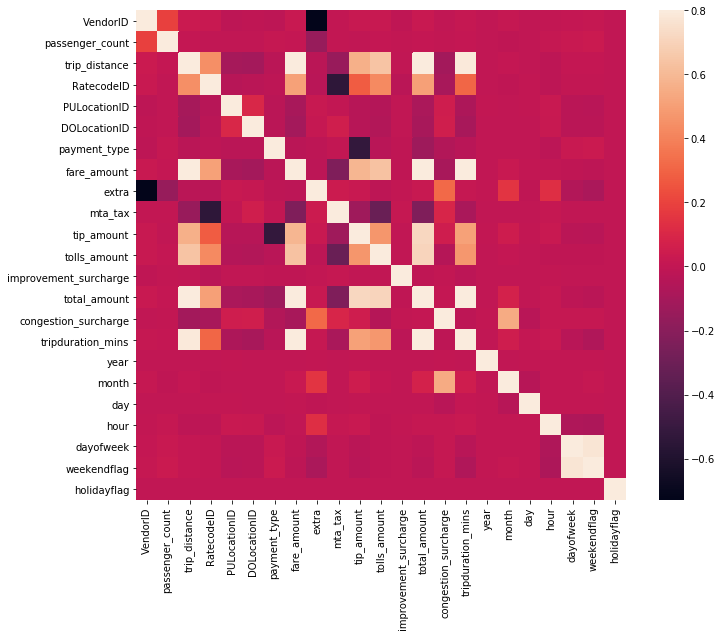

In [72]:
corrmat = df_taxi.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, xticklabels=True, yticklabels=True);

In [20]:
#scatter plot trip_distance/fare_amount
var = 'trip_distance'
data = pd.concat([df_taxi['fare_amount'], df_taxi[var]], axis=1)

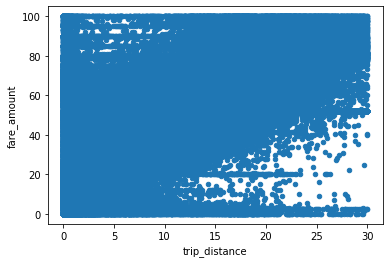

In [23]:
data.plot.scatter(x=var, y='fare_amount'); #, ylim=(0,100)

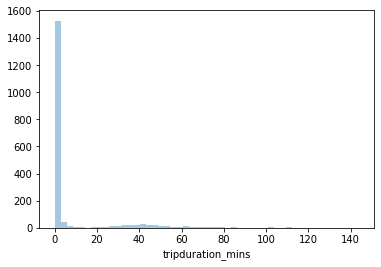

In [32]:
#The trip duration histogram
exception_trips = df_taxi.loc[(df_taxi['fare_amount'] < 10) & (df_taxi['trip_distance'] > 12)]
exception_trips.shape
sns.distplot(exception_trips['tripduration_mins'], kde=False, norm_hist=False);

In [30]:
#scatter plot trip duration/fare amount
data2 = pd.concat([exception_trips['fare_amount'], exception_trips['tripduration_mins']], axis=1)

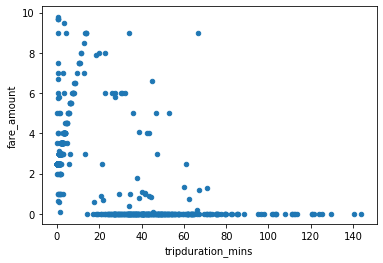

In [31]:
data2.plot.scatter(x='tripduration_mins', y='fare_amount'); #, ylim=(0,100)

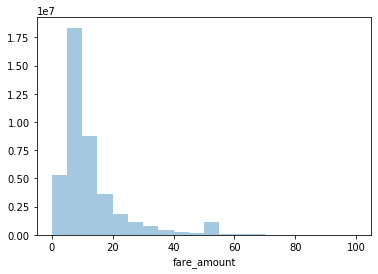

In [65]:
#Fare amount histogram
sns.distplot(df_taxi['fare_amount'], kde=False, norm_hist=False, bins = 20);

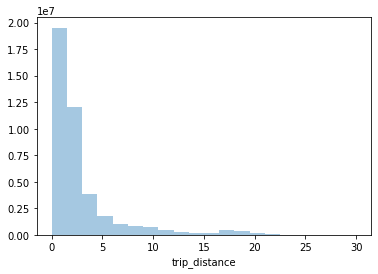

In [66]:
#Trip distance histogram
sns.distplot(df_taxi['trip_distance'], kde=False, norm_hist=False, bins = 20);

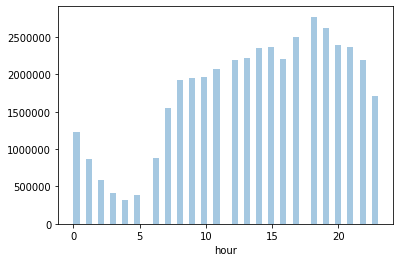

In [10]:
#Hours of the day histogram
sns.distplot(df_taxi['hour'], kde=False, norm_hist=False);

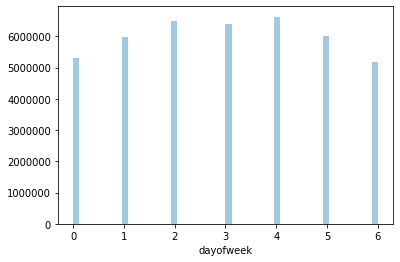

In [11]:
#Day of week histogram
sns.distplot(df_taxi['dayofweek'], kde=False, norm_hist=False);

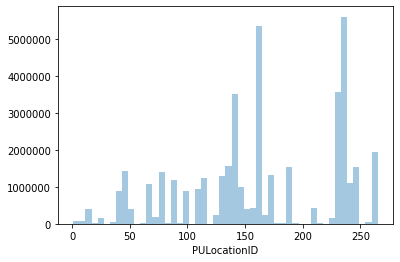

In [19]:
#Pickup locations histogram
sns.distplot(df_taxi['PULocationID'], kde=False, norm_hist=False);

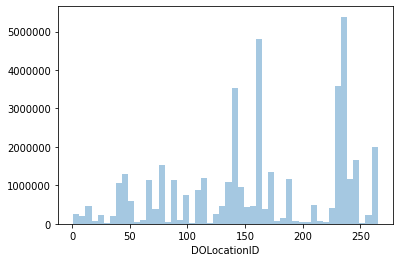

In [13]:
#Drop-off locations histogram
sns.distplot(df_taxi['DOLocationID'], kde=False, norm_hist=False);

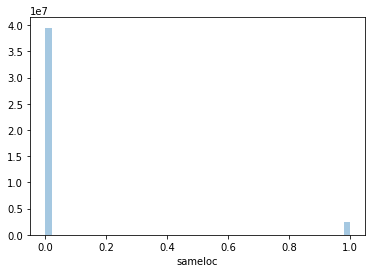

In [17]:
#Same location histogram
sns.distplot(df_taxi['sameloc'], kde=False, norm_hist=False);

In [6]:
((df_taxi['trip_distance']/5).astype(int)*5).loc[:].value_counts()

0     36059572
5      3483409
10     1153709
15     1074849
20      226491
25       36733
30         101
Name: trip_distance, dtype: int64

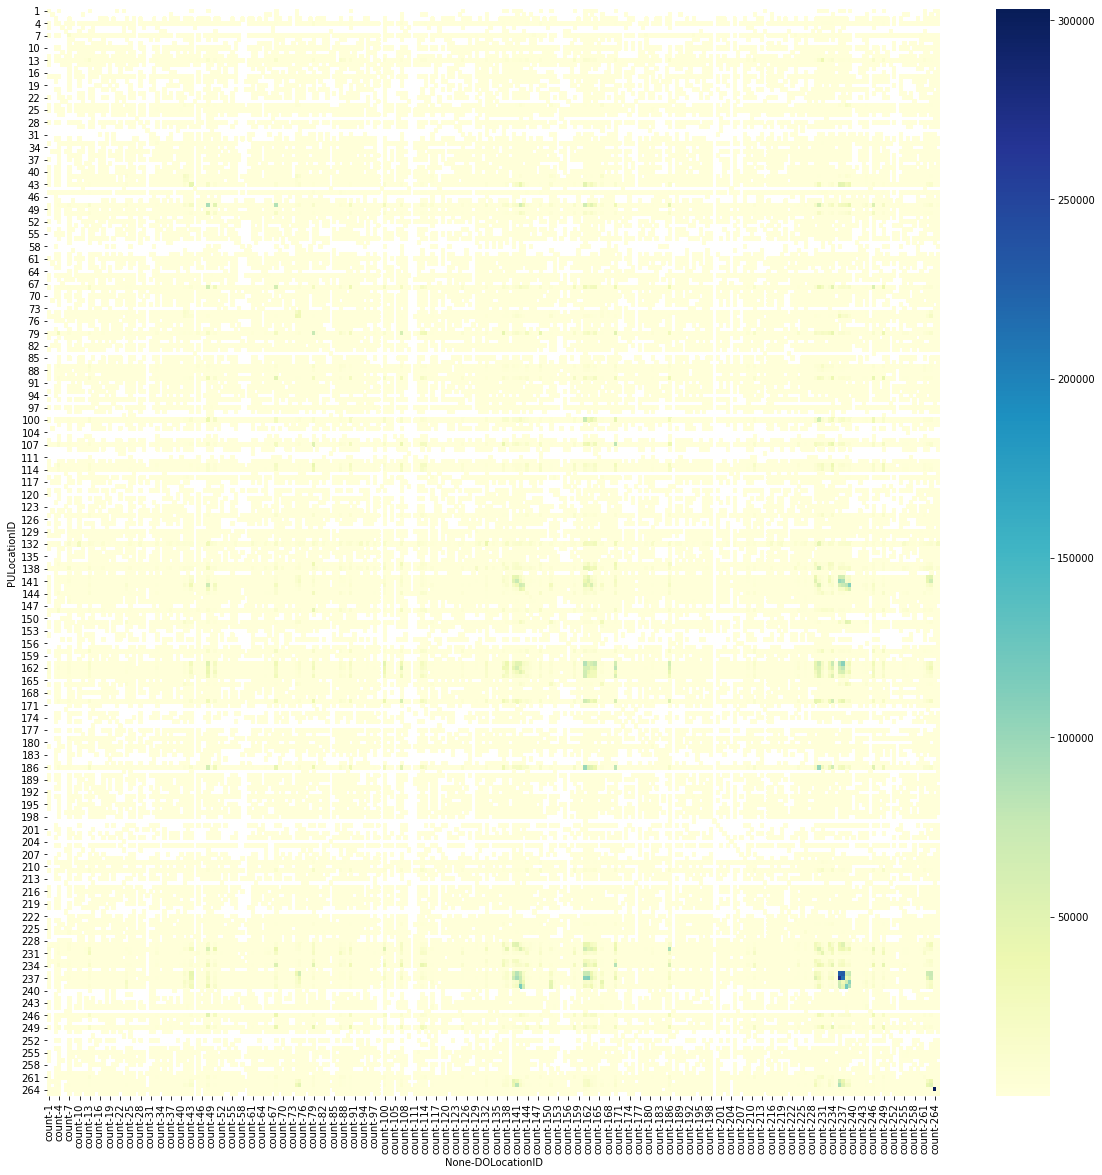

In [28]:
Loc_Dist = pd.pivot_table(df_taxi, index = 'PULocationID', columns = 'DOLocationID', values = 'VendorID', aggfunc = ['count'])
#Loc_Dist = pd.pivot_table(df_taxi, index = ['PULocationID', 'DOLocationID'], values = 'VendorID', aggfunc = ['count'])
#print(Loc_Dist)
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(Loc_Dist, cmap="YlGnBu")

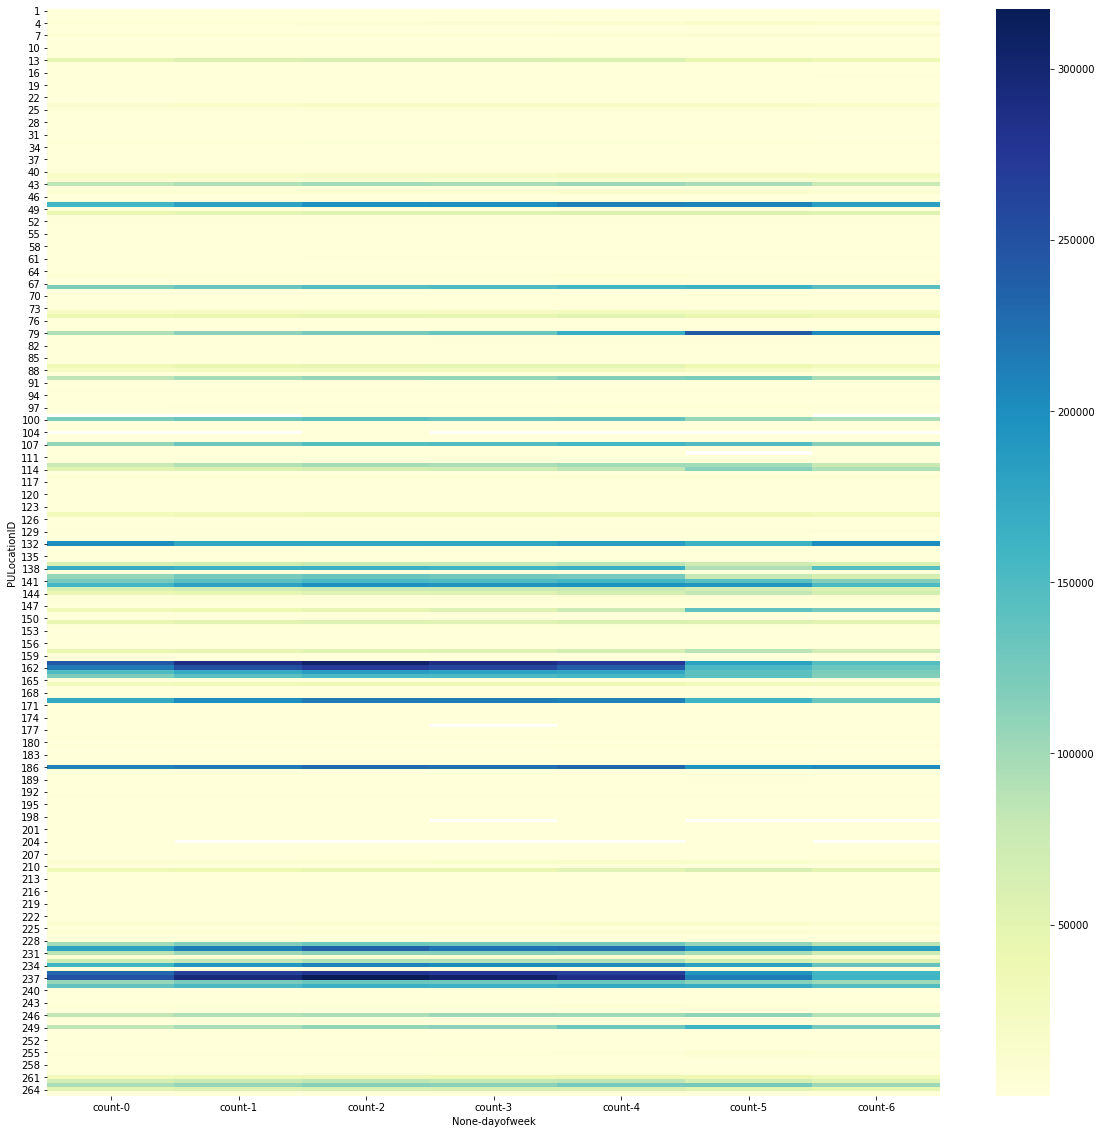

In [29]:
#Heatmap for pickup locations over days of the week
Loc_Dist = pd.pivot_table(df_taxi, index = 'PULocationID', columns = 'dayofweek', values = 'VendorID', aggfunc = ['count'])
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(Loc_Dist, cmap="YlGnBu")

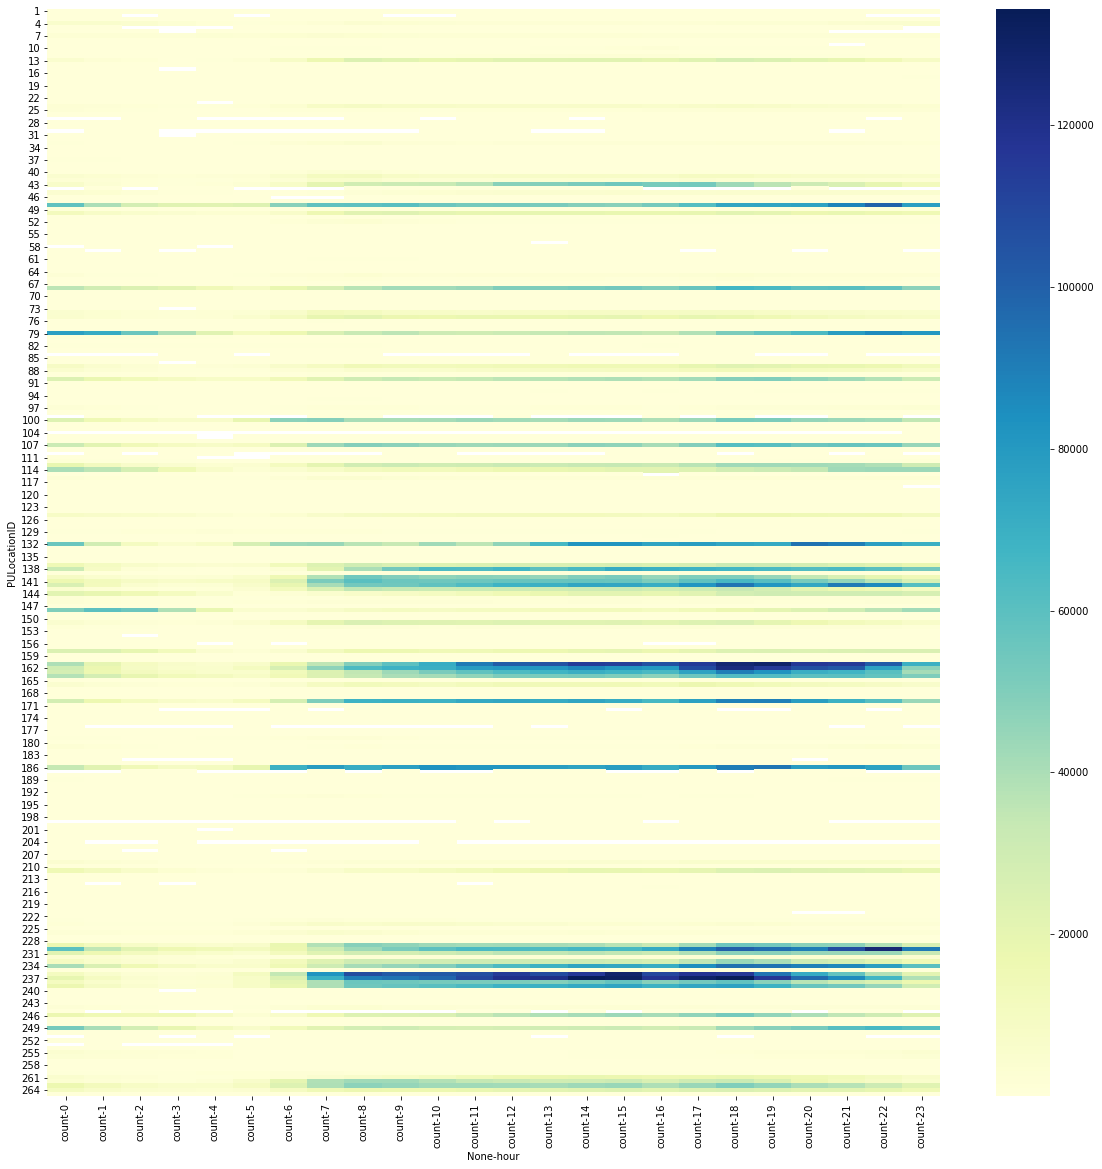

In [30]:
#Heatmap for pickup locations over hours of the day
Loc_Dist = pd.pivot_table(df_taxi, index = 'PULocationID', columns = 'hour', values = 'VendorID', aggfunc = ['count'])
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(Loc_Dist, cmap="YlGnBu")

In [10]:
PULocations = pd.merge(
    df_taxi['PULocationID'],
    df_lookup_zone,
    how="inner",
    left_on='PULocationID',
    right_on='LocationID',
    sort=True
)

PULocations.head()

,PULocationID,LocationID,Borough,Zone,service_zone
0,1,1,EWR,Newark Airport,EWR
1,1,1,EWR,Newark Airport,EWR
2,1,1,EWR,Newark Airport,EWR
3,1,1,EWR,Newark Airport,EWR
4,1,1,EWR,Newark Airport,EWR


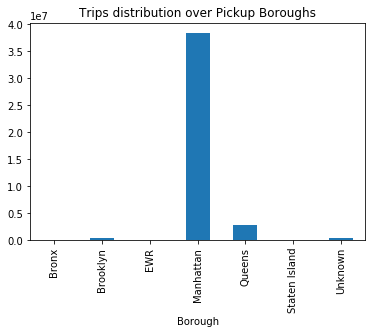

In [24]:
#Trip distribution over NY Pickup Boroughs
PULocations.groupby(['Borough']).count()['LocationID'].plot(kind="bar", title = 'Trips distribution over Pickup Boroughs'); #, fontsize=14, figsize = (30, 8)

In [23]:
DOLocations = pd.merge(
    df_taxi['DOLocationID'],
    df_lookup_zone,
    how="inner",
    left_on='DOLocationID',
    right_on='LocationID',
    sort=True
)

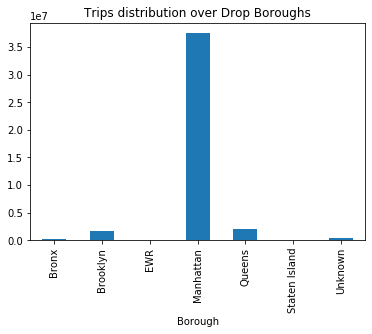

In [25]:
#Trip distribution over NY Dropoff Boroughs
DOLocations.groupby(['Borough']).count()['LocationID'].plot(kind="bar", title = 'Trips distribution over Drop Boroughs'); #, fontsize=14, figsize = (30, 8)

## Business Questions/Use Cases

### What are the most demanding areas at specific time?
#### for example below are top pick up locations for a specific day and hour (Thursday 7pm)

In [26]:
filtered_df = df_taxi[(df_taxi['dayofweek'] == 3) & (df_taxi['hour'] == 19)]['PULocationID']

TopPULocations = pd.merge(
    filtered_df,
    df_lookup_zone,
    how="inner",
    left_on='PULocationID',
    right_on='LocationID',
    sort=True
)

TopPULocations.head()

,PULocationID,LocationID,Borough,Zone,service_zone
0,1,1,EWR,Newark Airport,EWR
1,1,1,EWR,Newark Airport,EWR
2,3,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,3,3,Bronx,Allerton/Pelham Gardens,Boro Zone
4,3,3,Bronx,Allerton/Pelham Gardens,Boro Zone


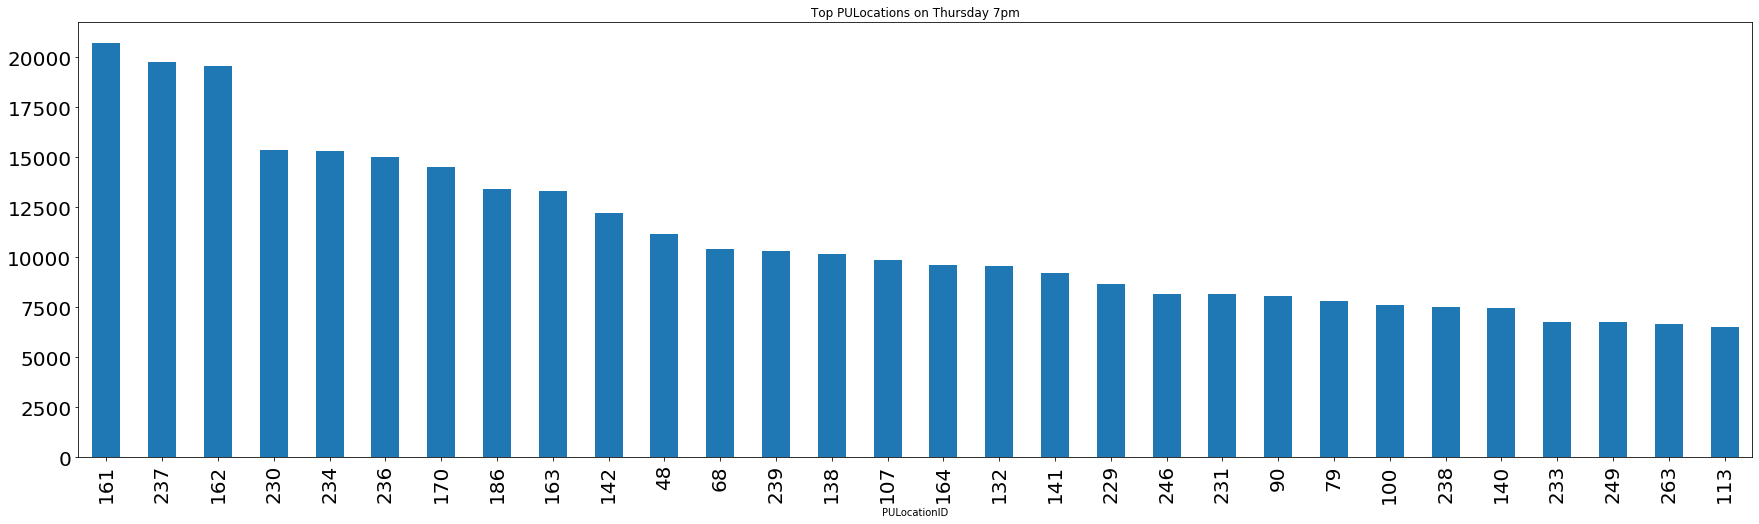

In [34]:
TopPULocations.groupby(['PULocationID']).count()['LocationID'].sort_values(ascending=False).head(30).plot(kind="bar", figsize = (30, 8), fontsize=20 , title = 'Top PULocations on Thursday 7pm'); #, fontsize=14, figsize = (30, 8)

### How to deploy the fleet based on driver’s preferences for drop off locations (a driver may prefer a drop off near his home)?
#### For example, below are top pick up locations for a specific day and hour (Thursday 7pm) which will most likely will lead to the favorite drop off locations [230, 234, 236]

In [42]:
DOList = [230, 234, 236]
filtered_df2 = df_taxi[(df_taxi['dayofweek'] == 3) & (df_taxi['hour'] == 19) & (df_taxi['DOLocationID'].isin(DOList))][['PULocationID', 'DOLocationID']]


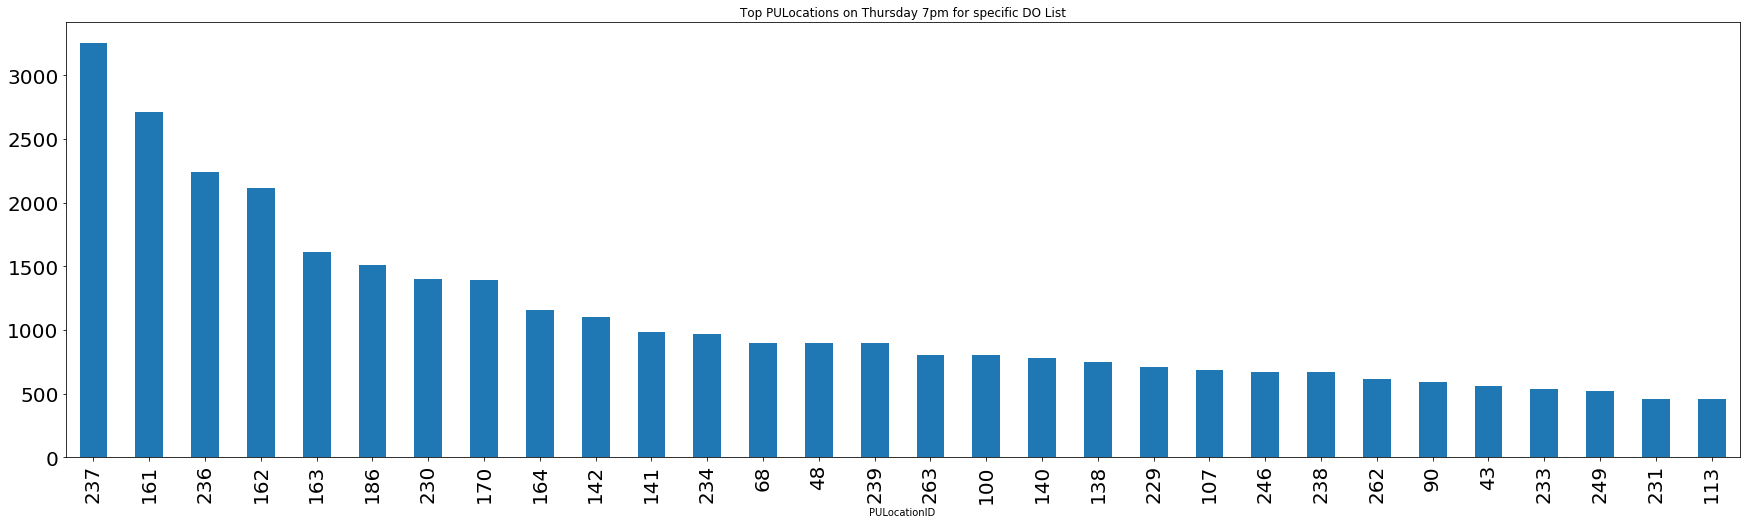

In [44]:
filtered_df2.groupby(['PULocationID']).count()['DOLocationID'].sort_values(ascending=False).head(30).plot(kind="bar", figsize = (30, 8), fontsize=20 , title = 'Top PULocations on Thursday 7pm for specific DO List'); #, fontsize=14, figsize = (30, 8)

### Now let's run our basic model to predict the Fare_Rate

### Scenario #1 Linear regression with all possible features as numeric

In [3]:
#Split into explanatory and response variables
X = df_taxi[['trip_distance', 'RatecodeID', 'tripduration_mins', 'month', 'hour', 'weekendflag', 'holidayflag', 'passenger_count', 'PULocationID', 'DOLocationID', 'payment_type']]
y = df_taxi['fare_amount']

In [4]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

#Clear memory to be able to run the model
del X
del y

In [5]:
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [10]:
#Predict and score the model on training and test data
y_train_preds, y_test_preds = print_model_scores(lm_model, X_train, X_test, y_train, y_test)

The r-squared score for our model on Training data is 0.9408655229497245 on 14712202 values.
The mean_squared_error score for our model on Training data is 6.879148895127688 on 14712202 values.
The root_mean_squared_error score for our model on Training data is 2.622813164357631 on 14712202 values.
 
The r-squared score for our model on Testing data is 0.9409164098556393 on 6305230 values.
The mean_squared_error score for our model on Testing data is 6.871197085487989 on 6305230 values.
The root_mean_squared_error score for our model on Testing data is 2.62129683276961 on 6305230 values.


In [11]:
#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
1,RatecodeID,4.877630,4.877630
0,trip_distance,1.789178,1.789178
6,holidayflag,-0.380822,0.380822
2,tripduration_mins,0.317012,0.317012
5,weekendflag,-0.079736,0.079736
3,month,0.021592,0.021592
4,hour,-0.006859,0.006859
10,payment_type,0.001454,0.001454
9,DOLocationID,-0.000803,0.000803
7,passenger_count,0.000387,0.000387


### Scenario #2 Linear regression using important features as numeric

In [12]:
#Split into explanatory and response variables
X = df_taxi[['trip_distance', 'RatecodeID', 'tripduration_mins', 'month', 'hour', 'weekendflag', 'holidayflag']]
y = df_taxi['fare_amount']

In [13]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
del X
del y

In [14]:
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model on training and test data
y_train_preds, y_test_preds = print_model_scores(lm_model, X_train, X_test, y_train, y_test)

The r-squared score for our model on Training data is 0.9408385370477721 on 14712202 values.
The mean_squared_error score for our model on Training data is 6.882288181156071 on 14712202 values.
The root_mean_squared_error score for our model on Training data is 2.623411553903823 on 14712202 values.
 
The r-squared score for our model on Testing data is 0.940890929867919 on 6305230 values.
The mean_squared_error score for our model on Testing data is 6.874160311265811 on 6305230 values.
The root_mean_squared_error score for our model on Testing data is 2.6218619931769505 on 6305230 values.


In [15]:
#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
1,RatecodeID,4.873097,4.873097
0,trip_distance,1.790674,1.790674
6,holidayflag,-0.357203,0.357203
2,tripduration_mins,0.317114,0.317114
5,weekendflag,-0.076037,0.076037
3,month,0.021624,0.021624
4,hour,-0.007014,0.007014


### Scenario #3 Linear regression with important features and OneHotEncoding for categorical features

In [6]:
#Split into explanatory and response variables
df_taxi_cat = df_taxi[['trip_distance', 'RatecodeID', 'tripduration_mins', 'month', 'hour', 'weekendflag', 'holidayflag', 'fare_amount']]
df_taxi_cat = df_taxi_cat.astype({'RatecodeID': 'object', 'month': 'object', 'hour': 'object'})

In [7]:
df_taxi_cat = create_dummy_df(df_taxi_cat, dummy_na=False)
del df_taxi

In [18]:
df_taxi_cat.head()

,trip_distance,tripduration_mins,weekendflag,holidayflag,fare_amount,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,9.94,16.250000,0,0,27.5,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1.33,11.600000,0,0,8.5,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1.84,10.183333,0,0,9.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.49,3.550000,0,0,4.5,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1.10,3.916667,0,0,5.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [8]:
#Split into explanatory and response variables
y = df_taxi_cat['fare_amount']
X = df_taxi_cat.drop('fare_amount', axis=1)
del df_taxi_cat

In [9]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
del X
del y

In [21]:
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [22]:
#Predict and score the model on training and test data
y_train_preds, y_test_preds = print_model_scores(lm_model, X_train, X_test, y_train, y_test)

The r-squared score for our model on Training data is 0.9432230301501271 on 14712202 values.
The mean_squared_error score for our model on Training data is 6.604898679993168 on 14712202 values.
The root_mean_squared_error score for our model on Training data is 2.5699997431893196 on 14712202 values.
 
The r-squared score for our model on Testing data is 0.943321447117103 on 6305230 values.
The mean_squared_error score for our model on Testing data is 6.591500388298767 on 6305230 values.
The root_mean_squared_error score for our model on Testing data is 2.567391748116903 on 6305230 values.


In [27]:
#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(50)

,est_int,coefs,abs_coefs
5,RatecodeID_3.0,21.094494,21.094494
7,RatecodeID_5.0,17.677541,17.677541
6,RatecodeID_4.0,15.300913,15.300913
4,RatecodeID_2.0,3.953922,3.953922
8,RatecodeID_6.0,-3.822377,3.822377
0,trip_distance,1.793444,1.793444
9,month_2,0.534433,0.534433
15,month_8,0.531600,0.531600
19,month_12,0.522987,0.522987
17,month_10,0.379549,0.379549


### Scenario #4 XGBoost regressor with important features and onehotencoding for categorical features

In [4]:
#Split into explanatory and response variables
df_taxi_cat = df_taxi[['trip_distance', 'RatecodeID', 'tripduration_mins', 'month', 'hour', 'weekendflag', 'holidayflag', 'fare_amount']]
df_taxi_cat = df_taxi_cat.astype({'RatecodeID': 'object', 'month': 'object', 'hour': 'object'})

In [9]:
df_taxi_cat = create_dummy_df(df_taxi_cat, dummy_na=False)
del df_taxi

In [11]:
#Split into explanatory and response variables
y = df_taxi_cat['fare_amount']
X = df_taxi_cat.drop('fare_amount', axis=1)
del df_taxi_cat

In [12]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
del X
del y

In [13]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,vmax_depth = 5, alpha = 10, n_estimators = 10) # Instantiate
xg_reg.fit(X_train, y_train) #Fit

[14:03:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:03:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { vmax_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='approx',
             validate_parameters=1, verbosity=None, vmax_depth=5)

In [15]:
#Predict and score the model on training and test data
y_train_preds, y_test_preds = print_model_scores(xg_reg, X_train, X_test, y_train, y_test)

The r-squared score for our model on Training data is 0.3242116292704751 on 14712202 values.
The mean_squared_error score for our model on Training data is 78.61486320225254 on 14712202 values.
The root_mean_squared_error score for our model on Training data is 8.866502309380659 on 14712202 values.
 
The r-squared score for our model on Testing data is 0.32425626984223854 on 6305230 values.
The mean_squared_error score for our model on Testing data is 78.58642878423606 on 6305230 values.
The root_mean_squared_error score for our model on Testing data is 8.86489869001536 on 6305230 values.


### Scenario #5 XGBoost regressor with modified hyper parameters

In [28]:
#Change the n_estimators from 10 to 50
xg_reg2 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,vmax_depth = 5, alpha = 10, n_estimators = 50) # Instantiate
xg_reg2.fit(X_train, y_train) #Fit

[01:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[01:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { vmax_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='approx',
             validate_parameters=1, verbosity=None, vmax_depth=5)

In [29]:
#Predict and score the model on training and test data
y_train_preds, y_test_preds = print_model_scores(xg_reg2, X_train, X_test, y_train, y_test)

The r-squared score for our model on Training data is 0.9636330518992762 on 14712202 values.
The mean_squared_error score for our model on Training data is 4.230588707727396 on 14712202 values.
The root_mean_squared_error score for our model on Training data is 2.056839494887094 on 14712202 values.
 
The r-squared score for our model on Testing data is 0.9638064313943984 on 6305230 values.
The mean_squared_error score for our model on Testing data is 4.2091745357480885 on 6305230 values.
The root_mean_squared_error score for our model on Testing data is 2.0516272896771697 on 6305230 values.
